<a href="https://colab.research.google.com/github/vinayykkumar/Visionary-Advanced-Image-Recognition-for-the-Next-Era_Infosys_Internship_Oct2024/blob/nivas/AIRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imageio

# Specify the path to your .zip file
zip_file_path = '/content/drive/MyDrive/datasets (1)/dataset2.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # List all the contents of the zip file
    file_list = z.namelist()

    # Loop through each file in the zip archive
    for file in file_list:
        if file.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Read the image file
            with z.open(file) as image_file:
                # Open the image
                image = Image.open(io.BytesIO(image_file.read()))

                # Convert the image to a NumPy array
                image_np = np.array(image)

                # Apply denoising filter
                if image_np.ndim == 3:  # Color image
                    image_denoised = cv2.fastNlMeansDenoisingColored(image_np, None, 10, 10, 7, 21)
                else:  # Grayscale image
                    image_denoised = cv2.fastNlMeansDenoising(image_np, None, 10, 7, 21)

                # Convert back to PIL Image
                image_denoised_pil = Image.fromarray(image_denoised)

                # Convert the denoised image to grayscale
                image_grey = image_denoised_pil.convert('L')

                # Convert the grayscale image to a NumPy array for face detection
                image_grey_np = np.array(image_grey)

                # Apply histogram equalization
                image_grey_np = cv2.equalizeHist(image_grey_np)

                # Load the face cascade
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

                # Detect faces in the image
                faces = face_cascade.detectMultiScale(image_grey_np, scaleFactor=1.1, minNeighbors=5)

                # Draw rectangles around the faces
                for (xf, yf, wf, hf) in faces:
                    cv2.rectangle(image_grey_np, (xf, yf), (xf + wf, yf + hf), (0, 0, 0), 1)

                # Create a subplot with 1 row and 2 columns
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))

                # Display the original denoised image
                axs[0].imshow(image_denoised_pil)
                axs[0].set_title(f'Original - {file}')
                axs[0].axis('on')  # Show the axes

                # Display the grayscale image with detected faces
                axs[1].imshow(image_grey_np, cmap='gray')
                axs[1].set_title(f'Grayscale with Faces - {file}')
                axs[1].axis('on')  # Show the axes

                # Show the plot
                plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datasets (1)/dataset2.zip'

In [ ]:
import numpy as np
from PIL import Image
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Function to resize image
def resize_image(image, size=(256, 256)):
    return image.resize(size, Image.LANCZOS)

# Function to normalize image
def z_score_normalize(image):
    image_array = np.array(image).astype('float32')
    mean = np.mean(image_array)
    std = np.std(image_array)
    normalized_image_array = (image_array - mean) / std
    return normalized_image_array

# Function to detect faces and crop the image
def detect_and_crop_face(image_path, face_cascade):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Crop the first face found
    for (x, y, w, h) in faces:
        cropped_face = image[y:y+h, x:x+w]
        return Image.fromarray(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))

    return None  # Return None if no face is detected

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Supported image extensions
supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

# Iterate over each file in the extracted dataset directory
for root, dirs, files in os.walk('/content/drive/MyDrive/datasets (1)/augmented_images'):
    for file in files:
        if file.lower().endswith(supported_extensions):
            input_image_path = os.path.join(root, file)

            # Step 1: Detect and crop face from the image
            try:
                cropped_image = detect_and_crop_face(input_image_path, face_cascade)
                if cropped_image is None:
                    print(f"No face detected in {input_image_path}")
                    continue
            except Exception as e:
                print(f"Error processing image {input_image_path}: {e}")
                continue

            # Step 2: Resize the cropped image
            try:
                resized_image = resize_image(cropped_image)
            except Exception as e:
                print(f"Error resizing image {input_image_path}: {e}")
                continue

            # Step 3: Normalize the resized image
            normalized_image_array = z_score_normalize(resized_image)

            # Step 4: Convert the normalized image array back to an image for augmentation
            normalized_image = Image.fromarray(((normalized_image_array - normalized_image_array.min()) /
                                                (normalized_image_array.max() - normalized_image_array.min()) * 255).astype('uint8'))

            # Step 5: Convert PIL image to array for Keras
            x = img_to_array(normalized_image)
            x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

            # Generate batches of augmented images and save them in a subdirectory based on the original filename
            filename_without_extension = os.path.splitext(file)[0]
            save_subdir = os.path.join(root, 'augmented', filename_without_extension)

            # Ensure the directory exists
            os.makedirs(save_subdir, exist_ok=True)

            print(f"Saving augmented images to: {save_subdir}")

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_subdir, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i > 20:  # Generate 20 augmented images per original image
                    break
        else:
            print(f"Skipping non-image file: {file}")

print("Image processing and augmentation complete.")


Image processing and augmentation complete.


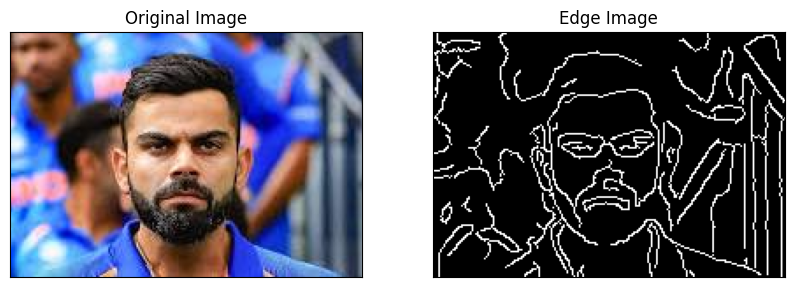

In [ ]:

from matplotlib import pyplot as plt

def edge_detection(input_image_path, output_image_path=None):
    # Load the image
    image = cv2.imread(input_image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, 100, 200)

    # Save the resulting image if output path is provided
    if output_image_path:
        cv2.imwrite(output_image_path, edges)

    # Display the original and edge-detected images
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

# Example usage
input_image_path = '/content/drive/MyDrive/datasets/vk.jpg'
output_image_path = '/content/drive/MyDrive/datasets/vk edge.jpg'
edge_detection(input_image_path, output_image_path)


In [ ]:
pip install tensorflow keras


In [ ]:
path_to_data = "/content/drive/MyDrive/datasets/dataset2"
path_to_cr_data = "/content/drive/MyDrive/datasets/cr data"
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/datasets/dataset2/ben_stokes',
 '/content/drive/MyDrive/datasets/dataset2/bhuvneshwar_kumar',
 '/content/drive/MyDrive/datasets/dataset2/dale_steyn',
 '/content/drive/MyDrive/datasets/dataset2/dinesh_karthik',
 '/content/drive/MyDrive/datasets/dataset2/hardik_pandya',
 '/content/drive/MyDrive/datasets/dataset2/jasprit_bumrah',
 '/content/drive/MyDrive/datasets/dataset2/k._l._rahul',
 '/content/drive/MyDrive/datasets/dataset2/kuldeep_yadav',
 '/content/drive/MyDrive/datasets/dataset2/mitchell_starc',
 '/content/drive/MyDrive/datasets/dataset2/rohit_sharma',
 '/content/drive/MyDrive/datasets/dataset2/virat_kohli',
 '/content/drive/MyDrive/datasets/dataset2/shikhar_dhawan']

In [ ]:
import cv2

def get_cropped_image_if_2_eyes(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the face and eye cascade classifiers
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Get the region of interest (ROI) for the face
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = image[y:y + h, x:x + w]

        # Detect eyes in the ROI
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            # Return the ROI with the face if it contains at least 2 eyes
            return roi_color

    return None

# Now the main part of the script
import os
import shutil

path_to_cr_data = '/content/drive/MyDrive/datasets/cr data'  # Define the path to your cropped data directory
img_dirs = ['/content/drive/MyDrive/datasets/dataset2/ben_stokes',
 '/content/drive/MyDrive/datasets/dataset2/bhuvneshwar_kumar',
 '/content/drive/MyDrive/datasets/dataset2/dale_steyn',
 '/content/drive/MyDrive/datasets/dataset2/dinesh_karthik',
 '/content/drive/MyDrive/datasets/dataset2/hardik_pandya',
 '/content/drive/MyDrive/datasets/dataset2/jasprit_bumrah',
 '/content/drive/MyDrive/datasets/dataset2/k._l._rahul',
 '/content/drive/MyDrive/datasets/dataset2/kuldeep_yadav',
 '/content/drive/MyDrive/datasets/dataset2/mitchell_starc',
 '/content/drive/MyDrive/datasets/dataset2/rohit_sharma',
 '/content/drive/MyDrive/datasets/dataset2/virat_kohli',
 '/content/drive/MyDrive/datasets/dataset2/shikhar_dhawan']  # Define your list of image directories

# Remove existing cropped data directory if it exists and create a new one
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

cropped_image_dirs = []
celebrity_file_names_dict = {}

# Iterate over each directory in img_dirs
for img_dir in img_dirs:
    count = 1
    celebrity_name = os.path.basename(img_dir)
    celebrity_file_names_dict[celebrity_name] = []

    # Iterate over each file in the directory
    for entry in os.scandir(img_dir):
        if entry.is_file():
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder:", cropped_folder)

                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

# Print final output for verification
print("Cropped image directories:", cropped_image_dirs)
print("Celebrity file names dictionary:", celebrity_file_names_dict)


Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/ben_stokes
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/bhuvneshwar_kumar
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/dale_steyn
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/dinesh_karthik
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/hardik_pandya
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/jasprit_bumrah
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/k._l._rahul
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/kuldeep_yadav
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/mitchell_starc
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/rohit_sharma
Generating cropped images in folder: /content/drive/MyDrive/datasets/cr data/virat_kohli
Gen

In [ ]:
celebrity_file_names_dict

{'ben_stokes': ['/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes1.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes2.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes3.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes4.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes5.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes6.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes7.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes8.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes9.png',
  '/content/drive/MyDrive/datasets/cr data/ben_stokes/ben_stokes10.png'],
 'bhuvneshwar_kumar': ['/content/drive/MyDrive/datasets/cr data/bhuvneshwar_kumar/bhuvneshwar_kumar1.png',
  '/content/drive/MyDrive/datasets/cr data/bhuvneshwar_kumar/bhuvneshwar_kumar2.png',
  '/content/drive/MyDrive/datasets/cr data/bhuvneshwar_kumar/bhuvneshwa

In [ ]:
import os
path_to_cr_data='/content/drive/MyDrive/datasets/train_detected_faces'
celebrity_names = [d.name for d in os.scandir(path_to_cr_data) if d.is_dir()]
celebrity_names

['Aamir Khan',
 'Aishwarya Rai',
 'Ajay Devgn',
 'Alia Bhatt',
 'Amitabh Bachchan',
 'Angelina Jolie',
 'Anushka Sharma',
 'Deepika Padukone',
 'Disha Patani',
 'IIeana DCruz']

In [ ]:
import os

# Example path to the dataset directory
dataset_directory = '/content/drive/MyDrive/datasets/train_detected_faces'

# Initialize the dictionary
celebrity_file_names_dict = {}

# Populate the dictionary with file paths
for celebrity_name in os.listdir(dataset_directory):
    celebrity_folder_path = os.path.join(dataset_directory, celebrity_name)
    if os.path.isdir(celebrity_folder_path):
        file_list = [os.path.join(celebrity_folder_path, file_name)
                     for file_name in os.listdir(celebrity_folder_path)
                     if file_name.endswith(('.png', '.jpg', '.jpeg'))]
        celebrity_file_names_dict[celebrity_name] = file_list


In [ ]:
pip install pywavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 591.5 kB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import pywt

# Function for wavelet transform
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255

   fs = pywt.wavede coefc2(imArray, mode, level=level)

    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H


In [ ]:
X, y = [], []
class_dict = {name: idx for idx, name in enumerate(celebrity_file_names_dict.keys())}

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
X_train = []
y_train = []
for name in celebrity_names:
    for img_path in os.listdir(os.path.join(path_to_cr_data, name)):
        img = Image.open(os.path.join(path_to_cr_data, name, img_path))
        img = img.resize((64, 64))
        img_array = np.array(img)
        X_train.append(img_array)
        y_train.append(celebrity_names.index(name))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1343, 64, 64, 3)

In [ ]:

y_train.shape

(1343,)

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Input(shape=(64, 64, 3)))  # Input layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(celebrity_names), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=2, validation_data=(X_val, y_val))

Epoch 1/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.1218 - loss: 10.6222 - val_accuracy: 0.1369 - val_loss: 2.2988
Epoch 2/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.1551 - loss: 2.3104 - val_accuracy: 0.1726 - val_loss: 2.2260
Epoch 3/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.1523 - loss: 2.3593 - val_accuracy: 0.0744 - val_loss: 2.3029
Epoch 4/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.1406 - loss: 2.2854 - val_accuracy: 0.1518 - val_loss: 2.2574
Epoch 5/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.2141 - loss: 2.1728 - val_accuracy: 0.2232 - val_loss: 2.1043
Epoch 6/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.2795 - loss: 1.9585 - val_accuracy: 0.3720 - val_loss: 1.8113
Epoch 7/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.3732 - loss: 1.7777 - val_accuracy: 0.3810 - val_loss: 1.7736
Epoch 8/50
672/672 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.4260 - loss: 1.5881 -